# Gene target analysis

Cell factory engineering strategies can be used to improve the production of progesterone in our modelled S. cerevisiae strain (iMM904_progesterone.xml).

We investigate if gene knockouts suggested in literature actually have an improving effect on the production of progesterone, and if it would be appropiate to incorporate these gene knockouts in our model. 

Using OptGene from cameo, we investigate if there are other potential gene knockout strategies that could be used to improve the production of progesterone.

Finally, we perform flux scanning based enforced objective flux (FSEOF) analysis to investigate reactions that are significantly up- or down-regulated as a result of an enhanced flux towards progesterone. This analysis reveals up- and downregulation targets. 

In [1]:
# Load libraries
from cobra.io import read_sbml_model
from cameo.strain_design import OptGene
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from matplotlib import pyplot as plt
from pytest import approx
import numpy as np
import pandas as pd

### Knockout analysis

It has been suggested to knockout ERG5 and ERG6 in order to drive the flux towards the production of cholesterol instead of the natural produced steriod ergosterol (Figure 1) (Jiang, Yi-qi, and Jian-ping Lin 2022). It is from zymosterol, the knockouts should improve the flux towards cholesterol. It might improve the production of progesterone because cholesterol is an intermediate in the implemented heterologous pathway. However, it can be problematic to knockout ERG5 and ERG6 because ergosterol is an essential compound in the cellular membrane of S. cerevisiae (Jordá, Tania, and Sergi Puig 2020).

![figures/3_Fig1_Steriods_ERG5_ERG6.png](figures/3_Fig1_Steriods_ERG5_ERG6.png)

Figure 1 (Jiang, Yi-qi, and Jian-ping Lin 2022)

A Synthesis of steroids. Solid arrows represent reactions validated in yeast, and dashed arrows implicate conversions catalyzed by 
unknown enzyme(s). The endogenous ergosterol pathway in yeast is highlighted in blue. The three different sheds of blue represented three modules: mevalonate (MVA) biosynthesis, farnesyl pyrophosphate (FPP) biosynthesis and ergosterol biosynthesis. Heterologous synthesis of animal-derived steroids in yeast already or potentially is highlighted in orange. Heterologous synthesis of phytosterols already or potentially in yeast is highlighted in green. The reaction catalyzed by UV-light is highlighted in yellow and common steroids involved in biotransformation is highlighted in purple. The enzymes marked in red represent the ones that require NADPH/NADP+, and the ones that require ATP are marked in purple. 

B The numbering of steroid’s carbon skeleton

We investigate the influence it has on the cell to knockout ERG5 and ERG6.

In [2]:
# Load model
model = read_sbml_model('models/iMM904_progesterone.xml')
model
# Rune forslag:
#  infilename = 'models/iMM904_progesterone.xml'
# print(f"Loading {infilename}")
# model = load_model(infilename)

Name,iMM904_progesterone
Memory address,0x07f501a1c3ac0
Number of metabolites,1234
Number of reactions,1586
Number of groups,0
Objective expression,1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
Compartments,"cytosol, extracellular space, mitochondria, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, golgi apparatus, nucleus"


In [3]:
# Progesterone is released from the cell
model.add_boundary(model.metabolites.get_by_id("progesterone_c"), type="demand")

# Rune forslag:
# model.add_boundary(model.metabolites.get_by_id('progesterone_c'), type='demand')
# print(f'Adding reaction {model.reactions.DM_progesterone_c.name}: {model.reactions.DM_progesterone_c.reaction}')

Reaction identifier,DM_progesterone_c
Name,progesterone demand
Memory address,0x07f506c184b20
Stoichiometry,progesterone_c --> progesterone -->
GPR,
Lower bound,0
Upper bound,1000.0


In [5]:
# Knockout ERG5 and ERG6
model_ERG5_ERG6 = model.copy()
model_ERG5_ERG6.genes.YMR015C.knock_out() # ERG5 knockout implemented
model_ERG5_ERG6.genes.YML008C.knock_out() # ERG6 knockout implemented

# Rune: Ikke elegant men forslag til måde at teste i samme celle som laver knock outs
# if model_ERG5_ERG6.genes.YMR015C.functional == False:
#     print("ERG5 knockout: True")
# if model_ERG5_ERG6.genes.YML008C.functional == False:
#     print("ERG6 knockout: True")

In [13]:
# check ERG5 knockout
model_ERG5_ERG6.genes.YMR015C

Gene identifier,YMR015C
Name,ERG5
Memory address,0x07f46c3894ca0
Functional,False
In 2 reaction(s),"C22STDS, C22STDSx"


In [14]:
# check ERG6 knockout
model_ERG5_ERG6.genes.YML008C

Gene identifier,YML008C
Name,ERG6
Memory address,0x07f46c38a4cd0
Functional,False
In 1 reaction(s),SAM24MT


In [28]:
# ERG5 and ERG6 knockout influence on growth (default objective function)
print('Growth in model: µ =', round(model.optimize().objective_value,3))
print('Growth when ERG5 and ERG6 knocked out: µ =', round(model_ERG5_ERG6.optimize().objective_value,3))

Growth in model: µ = 0.288
Growth when ERG5 and ERG6 knocked out: µ = 0.288


In [30]:
# ERG5 and ERG6 knockout influence on progesterone production (objective set to progesterone forming reaction)
with model:
    model.objective = model.reactions.R02216
    print('Progesterone in model:', round(model.optimize().objective_value,3))

with model_ERG5_ERG6:
    model_ERG5_ERG6.objective = model_ERG5_ERG6.reactions.R02216
    print('Progesterone when ERG5 and ERG6 knocked out:', round(model_ERG5_ERG6.optimize().objective_value,3))

Progesterone in model: 0.143
Progesterone when ERG5 and ERG6 knocked out: 0.143


Surprisingly, knocking out ERG5 and ERG6 does not seem to influence the cell growth or the progesterone production. We further investigate if this is actually the case or if there is a problem in the model to take into account.

Our strategy for investigating this:
1. Be sure that the knockout function work as intended
2. Confirm that knocking out ERG5 and ERG6 has an influence on some reactions
3. Go through the ergosterol pathway in the model and verify that is coherent (a summary table is provided)

In [34]:
#1 Reaction where progesterone is formed
for reac in model.metabolites.progesterone_c.reactions:
    print(reac)

R02216: nad_c + pregnenolone_c <=> h_c + nadh_c + progesterone_c
DM_progesterone_c: progesterone_c --> 


In [33]:
#1 The gene encoding the enzyme driving the reaction where progesterone is formed
model.reactions.R02216.genes

frozenset({<Gene HSD3B at 0x7f5e64d34cd0>})

In [34]:
#1 Progesterone production when knocking out the gene encoding the enzyme driving the reaction
model_3betaHSD = model.copy()
model_3betaHSD.genes.HSD3B.knock_out()

with model:
    model.objective = model.reactions.R02216
    print('Progesterone in model:', round(model.optimize().objective_value,3))

with model_3betaHSD:
    model_3betaHSD.objective = model_3betaHSD.reactions.R02216
    print('Progesterone when 3beta-HSD knocked out:', round(model_3betaHSD.optimize().objective_value,3))


Progesterone in model: 0.143
Progesterone when 3beta-HSD knocked out: 0.0


When 3beta-HSD is knocked out, there is as expected no production of progesterone. It is verified that the knockout function works as intended. 

In [43]:
#2 Investigate if the knockout of ERG5 and ERG6 influences some reactions
fluxes = model.optimize().fluxes
fluxes_knockout = model_ERG5_ERG6.optimize().fluxes
for i, (flux, flux_knockout) in enumerate(zip(round(fluxes,3), round(fluxes_knockout,3))):
    if flux != flux_knockout:
        print(f'Reaction {fluxes.index[i]}: flux: {flux} is different from knockout_ERG5_ERG6 flux: {flux_knockout}')

Reaction H2Otm: flux: -7.421 is different from knockout_ERG5_ERG6 flux: -7.529
Reaction FRDcm: flux: 0.108 is different from knockout_ERG5_ERG6 flux: 0.0
Reaction MALtm: flux: -0.142 is different from knockout_ERG5_ERG6 flux: -0.502
Reaction MDH: flux: -0.124 is different from knockout_ERG5_ERG6 flux: 0.344
Reaction MDHm: flux: 0.468 is different from knockout_ERG5_ERG6 flux: 0.0
Reaction NADH2_u6cm: flux: 2.221 is different from knockout_ERG5_ERG6 flux: 2.688
Reaction NADH2_u6m: flux: 1.479 is different from knockout_ERG5_ERG6 flux: 1.012
Reaction FUM: flux: 0.0 is different from knockout_ERG5_ERG6 flux: 0.108
Reaction FUMm: flux: 0.344 is different from knockout_ERG5_ERG6 flux: 0.236
Reaction OAAt2m: flux: 0.0 is different from knockout_ERG5_ERG6 flux: 0.468
Reaction PIt2m: flux: 4.437 is different from knockout_ERG5_ERG6 flux: 3.969
Reaction SUCCtm: flux: 0.123 is different from knockout_ERG5_ERG6 flux: 0.015
Reaction SUCD1m: flux: 0.344 is different from knockout_ERG5_ERG6 flux: 0.

It makes a difference for the flux of some reactions when ERG5 and ERG6 is knocked out.
COMMENT on what reactions are different!!

The ergosterol pathway in the model starting from zymosterol is investigated by checking each reaction and the gene encoding the enzyme catalyzing the given reaction (Figure 1 in comparison to our model). One example is shown below, and a summary is seen in Table 1.

In [52]:
#3 reactions where zymosterol participate
for reac in model.metabolites.zymst_c.reactions:
    print(reac)

R04804: zymst_c --> cholesta724dien3betaol_c
R07498: h_c + nadph_c + zymst_c <=> cholesta8en3betaol_c + nadp_c
ZYMSTESTH_SC: h2o_c + 0.01 zymstest_SC_c --> h_c + 0.02 hdca_c + 0.655 hdcea_c + 0.01 hexc_c + 0.03 ocdca_c + 0.27 ocdcea_c + 0.015 ttdca_c + 0.01 zymst_c
ZYMSTAT_SC: 0.655 hdcoa_c + 0.01 hexccoa_c + 0.27 odecoa_c + 0.02 pmtcoa_c + 0.03 stcoa_c + 0.015 tdcoa_c + 0.01 zymst_c --> coa_c + 0.01 zymstest_SC_c
CHLSTI: amet_c + o2_c + zymst_c --> ahcys_c + ergtetrol_c + 2.0 h2o_c + h_c
C3STKR2: h_c + nadph_c + zym_int2_c --> nadp_c + zymst_c
ZYMSTt: zymst_e <=> zymst_c
BIOMASS_SC5_notrace: 1.1348 13BDglcn_c + 0.4588 ala__L_c + 0.046 amp_c + 0.1607 arg__L_c + 0.1017 asn__L_c + 0.2975 asp__L_c + 59.276 atp_c + 0.0447 cmp_c + 0.0066 cys__L_c + 0.0036 damp_c + 0.0024 dcmp_c + 0.0024 dgmp_c + 0.0036 dtmp_c + 0.0007 ergst_c + 0.1054 gln__L_c + 0.3018 glu__L_c + 0.2904 gly_c + 0.5185 glycogen_c + 0.046 gmp_c + 59.276 h2o_c + 0.0663 his__L_c + 0.1927 ile__L_c + 0.2964 leu__L_c + 0.2862 lys_

In [53]:
#3 reactions where ERG6 participate
model.genes.YML008C 

Gene identifier,YML008C
Name,ERG6
Memory address,0x07f46c46aaf10
Functional,True
In 1 reaction(s),SAM24MT


![figures/3_Fig1_Steriods_ERG5_ERG6.png](figures/Table1_ERG_pathway.png)

Table 1: Overview of ergosterol pathway in the model. Yellow background indicated that the reaction occurs in the cytoplasm and blue background indicated that the reaction happens in the ER.

All reactions in the ergosterol pathway (Figure 1) is present in the model. Next is to investigate the flux of the reactions.

FIND ud af om Ergosta-tetraen indgår andre steder.

In [10]:
erg_pathway = ['SAM24MT', 'C8STI', 'C5STDS', 'C22STDS', 'ERGTETROLter', 'C24STRer', 'ERGSTter']
with model_ERG5_ERG6:
    for reac in erg_pathway:
        model_ERG5_ERG6.objective = model_ERG5_ERG6.reactions.get_by_id(reac)
        print('Ergosterol when ERG5 and ERG6 is knocked out: ', round(model_ERG5_ERG6.optimize().objective_value,3))

Ergosterol when ERG5 and ERG6 is knocked out:  0.0
Ergosterol when ERG5 and ERG6 is knocked out:  0.0
Ergosterol when ERG5 and ERG6 is knocked out:  0.0
Ergosterol when ERG5 and ERG6 is knocked out:  0.0
Ergosterol when ERG5 and ERG6 is knocked out:  0.182
Ergosterol when ERG5 and ERG6 is knocked out:  0.182
Ergosterol when ERG5 and ERG6 is knocked out:  0.182


In [12]:
model.metabolites.ergtetrol_c

Metabolite identifier,ergtetrol_c
Name,Ergosta 5 7 22 24 28 tetraen 3beta ol C28H42O
Memory address,0x07f5039001970
Formula,C28H42O
Compartment,c
In 4 reaction(s),"ERGTETROLter, C22STDSx, C22STDS, CHLSTI"


In [13]:
model.reactions.CHLSTI

Reaction identifier,CHLSTI
Name,Cholestenol delta isomerase lumped reaction
Memory address,0x07f50389cdaf0
Stoichiometry,amet_c + o2_c + zymst_c --> ahcys_c + ergtetrol_c + 2.0 h2o_c + h_c S-Adenosyl-L-methionine + O2 O2 + Zymosterol C27H44O --> S-Adenosyl-L-homocysteine + Ergosta 5 7 22 24 28 tetraen 3beta ol C28H42O + 2.0 H2O H2O + H+
GPR,
Lower bound,0.0
Upper bound,999999.0


Der bliver lavet Ergosta i cytoplasm fra zymosterol. Derfor kommer der pludselig flux.

It is clear that it is not appropriate to knockout ERG5 and ERG6 for production progesterone. 

We investigate if knocking out other genes would improve the production of progesterone using OptGene from Cameo.

In [73]:
optgene = OptGene(model)
result = optgene.run(target=model.reactions.R02216,
                    biomass=model.reactions.BIOMASS_SC5_notrace, 
                    substrate=model.metabolites.glc__D_e, 
                    max_evalutations=50000, plot=False)

Starting optimization at Mon, 21 Nov 2022 22:46:20


HBox()

Finished after 00:19:33


In [74]:
result

No solutions found


,reactions,genes,size,fva_min,fva_max,target_flux,biomass_flux,yield,fitness


The cell engineering strategy of knocking out genes does not improve the production of progesterone. It can have adverse effects on the cell to knockout genes because there is a chance that it results in significant lowered fitness properties.

### Up-regulation and down-regulation targets

We use FSEOF analysis to find targets that are up- or down-regulated as a result of an increasing flux towards the production of progesterone.

In [62]:
# Run FSEOF analysis
fseof = FSEOF(model)
result=fseof.run(target=model.reactions.R02216)
df=result.data_frame
df

,1,2,3,4,5,6,7,8,9,10
2DDA7Ptm,-0.073295,-0.057095,-0.053743,-0.050390,-0.047038,-0.043685,-0.049581,-0.045420,-0.041113,0.000000
ACALDtm,-0.051995,0.000000,0.000000,0.000000,0.000000,0.000000,-0.543187,-1.100775,-1.636180,-1.764525
34HPPt2m,0.000000,0.027087,0.025496,0.023906,0.022316,0.020725,0.019135,0.017529,0.015866,0.014204
ACONT,0.173048,0.270551,0.254665,0.238779,0.222893,0.207007,0.191121,0.175079,0.158477,0.141874
ACtm,-0.051995,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
R01456,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571
ECYP11A1,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571
R07215,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571
R04804,0.012857,0.025714,0.038571,0.051429,0.064286,0.077143,0.090000,0.102857,0.115714,0.128571


In [64]:
# Reactions where there is a significant flux change
df = df.sort_values([1], ascending = False) # sorting the dataframe
lmt = 3
significant_flux_change = ((df > lmt) | (df < -lmt)).all(axis=1)
df = df.loc[significant_flux_change] # removing reactions from dataframe
df

,1,2,3,4,5,6,7,8,9,10
GAPD,18.018990,18.057998,18.209506,18.361014,18.512523,18.664031,18.815539,18.954090,19.045735,19.137381
ENO,17.860953,17.906662,18.067056,18.227450,18.387845,18.548239,18.708633,18.872678,19.045735,19.137381
PYK,17.714364,17.766288,17.934924,18.103561,18.272198,18.440835,18.609471,18.781839,18.963510,19.063770
PYRDC,15.907336,15.868990,15.890425,15.911860,15.933295,15.954729,15.976164,15.985631,15.930778,15.468864
ALCD2ir,15.781546,15.762371,15.790066,15.817761,15.845457,15.873152,15.357660,14.832382,14.320791,13.727789
HEX1,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
TPI,8.866319,8.869403,8.973267,9.077132,9.180997,9.284862,9.388726,9.479168,9.521021,9.562874
FBA,8.528249,8.500683,8.663677,8.826672,8.989666,9.152660,9.315654,9.451365,9.488318,9.525270
PFK,8.528249,8.500683,8.663677,8.826672,8.989666,9.152660,9.315654,9.451365,9.488318,9.525270
PGI,8.480666,8.410136,8.615926,8.821716,9.027506,9.233296,9.439086,9.603574,9.618556,9.633537


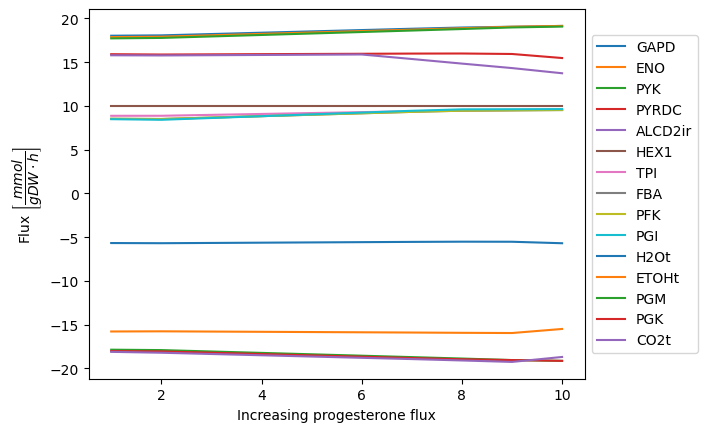

In [66]:
df.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Increasing progesterone flux");
plt.ylabel(r"Flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");
plt.show()

MAKE TABLE with overview of the enzymes that catalysis the reactions stated!

Text(0.5, 1.0, 'Flux scanning based on Enforced Objective Flux')

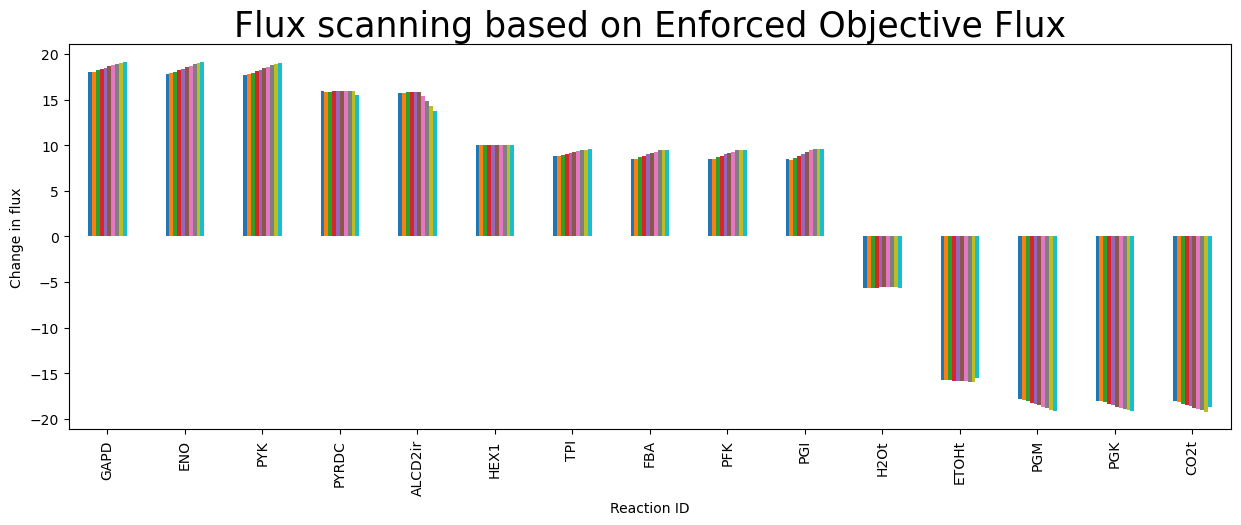

In [70]:
fig = df.plot(legend=None, kind='bar', figsize=(15, 5), grid =False);
fig.set_ylabel('Change in flux')
fig.set_xlabel('Reaction ID')
fig.set_title('Flux scanning based on Enforced Objective Flux', size=25)

This plot shows how the flux of a given reaction changes when the flux towards progesterone is increased. The columns from left to right within each reaction is due to an increased flux towards progesterone meaning that the relative flux change can be observed. For example, it might be more interesting to up-regulate GAPD instead of HEX1. GAPD flux increases when progesterone flux increases in constrast to HEX1 flux that remain the same.

### References
Jiang, Yi-qi, and Jian-ping Lin. "Recent progress in strategies for steroid production in yeasts." World Journal of Microbiology and Biotechnology 38.6 (2022): 1-14.

Jordá, Tania, and Sergi Puig. "Regulation of ergosterol biosynthesis in Saccharomyces cerevisiae." Genes 11.7 (2020): 795.